In [ ]:
import numpy as np
import math
import pandas as pd
from IPython.display import Image, display
from CoolProp.CoolProp import PropsSI
import import_ipynb
import matplotlib.pyplot as pl

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def F2K(F):
    return (F-32)*5/9 + 273.15

### Example 1
Select a two-row coil made of finned tubes in configuration C to heat an air flow of 10,000
$cfm$ from an entering temperature of 55 F to a leaving temperature of $75°F$. The hot water is delivered from a boiler at a
temperature of $160°F$ and drops $15°F$ through the coil. Determine the heating capacity of the coil, the water flow rate, air velocity, and coil dimensions.

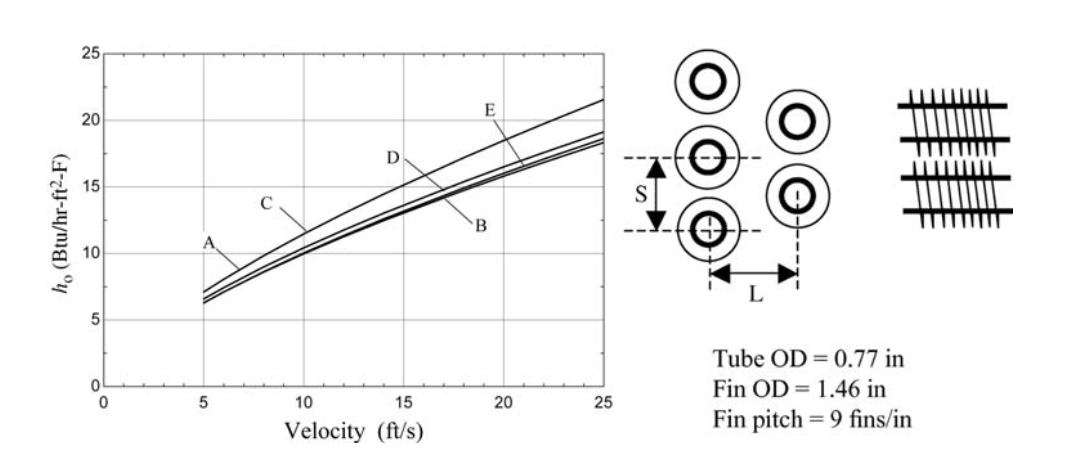

In [4]:
display(Image(filename='HeatTransferCoefficients.jpg')) 

##### Information given:

In [5]:
P_atm = 14.7 #standard atmosphere pressure,[psi]
V_dot_a = 10000 # air volume flow rate, [CFM]
T_a_i = 55 # air temperature entering the coil, [F]
T_a_o = 75 # air leaving temperature, [F]
T_w_i = 160 #water entering temperature,[F]
T_w_o = 160-15 # water leaving temperature,[F]

### 1. Determine the capacity of the coil:
$$\dot{Q}_{capacity} = \dot{m}_{air}c_p(T_{a,o}-T_{a,i})$$

In [6]:
rho_a = PropsSI('D','T',F2K(T_a_i),'P',P_atm*6894.76,'Air') * 0.062427960576145
c_p_a = PropsSI('C','T',F2K(T_a_i),'P',P_atm*6894.76,'Air') * 0.000238845896627
m_dot_a = V_dot_a * rho_a*60
Q_cap = m_dot_a * c_p_a * (T_a_o-T_a_i)
print('The capacity of heating coil is:',f"{Q_cap:.1f}",'[Btu/hr]') 

The capacity of heating coil is: 222367.3 [Btu/hr]


In [7]:
c_p_w = PropsSI('C','T',F2K(T_a_i),'P',P_atm*6894.76,'Water') * 0.000238845896627
m_dot_w = Q_cap/(c_p_w*(T_w_i-T_w_o))
print('Mass flow rate of water is:',f"{m_dot_w:.1f}",'[lbm/hr]') 

Mass flow rate of water is: 14809.2 [lbm/hr]


In [8]:
C_a = m_dot_a * c_p_a
C_w = m_dot_w * c_p_w
Cr = min(C_a,C_w)/max(C_a,C_w)
epsilon = Q_cap/(min(C_a,C_w)*(T_w_i-T_a_i))
Ntu = -math.log((1-epsilon)/(1-epsilon*Cr))*1/(1-Cr)
UA = Ntu*min(C_a,C_w)
R_total = 1/UA
print(R_total)

0.00039338603262910717


### Example 2
A hot water coil is used to preheat outdoor air before it is introduced into an air-handling unit. Outdoor air enters the heat exchanger at 0°F with a face velocity of 820 ft/min. The coil, which has a face area of 4 ft X 4 ft is constructed using heat exchanger surface 7.75-5/8t, shown below. Hot water is circulated through the coil in a single circuit, and enters the tubes at 170°F with a volumetric flow rate of 10 ft3/min. \
Find:
Determine the total heat transfer rate, and the outlet temperatures of the air and water. 



#### Given:

In [9]:
# Air side
T_a_in = 0 # Inlet temperature of air,[F]
v_face = 820 # Face velocity,[ft/min]
A_face = 4*4 # Face area, [ft2]
rho_a = 0.08627 # Air density,[lbm/ft2]
c_p_a = 0.24 # Specific heat of air,[Btu/lbm-°F]

# Water side
T_w_in = 170 # Inlet temperature of water,[F]
V_dot_w = 10 # Face velocity,[ft3/min]
rho_w = 60.6 # Water density,[lbm/ft2]
c_p_a = 0.24 # Specific heat of air,[Btu/lbm-°F]

#### The geometry of heat exchanger:

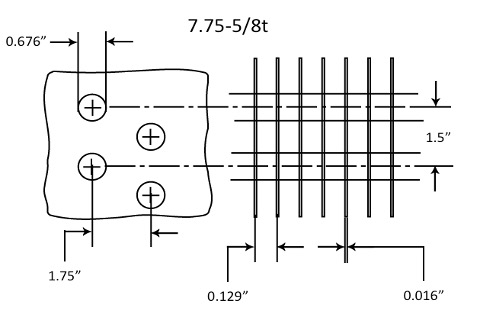

In [10]:
display(Image(filename='HXgeometry.jpg')) 

In [11]:
D_i = (0.676 - 2 * 0.0248)*0.0833333
D_o = 0.676 * 0.0833333
D_h = 0.0114 # air side hydraulic diameter,[ft]
N_tube = 4
A_tube = np.pi * D_i**2/4
A_min = 0.481 * A_face # Minimum free-flow area,[ft2]
A_total = 24.6 * A_face #Total outside area,[ft2]
A_fin = 0.913 * A_total # Fin area,[ft2]
A_u = A_total - A_fin # Unfined area[ft2]
A_in = A_total/20.5 # Total inside tube area,[ft2]
L = A_in/A_tube # total tube length,[ft]
eta_fin = 0.85 # Heat exchanger fin efficiency

#### Step 1: Determine mass flow rate:

In [12]:
# Air side:
V_dot_air = v_face * A_face # [CFM]
m_dot_air = V_dot_air * rho_a 
print('Mass flow rate of air is:',f"{m_dot_air:.2f}",'[lbm/min]') 

# Water side:
m_dot_water = rho_w * V_dot_w
print('Mass flow rate of water is:',f"{m_dot_water:.2f}",'[lbm/min]') 

Mass flow rate of air is: 1131.86 [lbm/min]
Mass flow rate of water is: 606.00 [lbm/min]


### Using $\epsilon-Ntu$ method to calculate the actual heating capacity rate
$$\dot{Q}_{capacity} = \epsilon * C_{min} * (T_{w,in}-T_{a,in})$$
where: 
The air and water capacity rate:\
$$C_{air} = \dot{m}_{air} * c_{p,air}; C_{water} = \dot{m}_{water} * c_{p,water}$$
The minimum and maximum capacity rate:\
$$C_{min} = \min (C_{air},C_{water}); C_{max} = \max (C_{air},C_{water})$$
The capacity rate ratio:\
$$Cr = \frac{C_{min}}{C_{max}}$$

To calculate the effectiness ($\epsilon$), it is required to calculate the number of transfer unit ($Ntu$):
$$Ntu = \frac{UA}{C_{min}}$$
where the overall heat transfer conductance:\
$$\frac{1}{UA} = \frac{1}{h_iA_i} + \frac{\ln{\frac{D_o}{D_i}}}{2\pi kL} + \frac{1}{h_o (A_u+\eta*A_f)}$$

So the effectiveness is:
$$\epsilon = 1-e^{\epsilon (1-Cr)}$$


#### Step 2: calculate air side and water side heat transfer coefficient $h_i$, $h_o$
Stanton number: $$N_{st} = \frac{h_o}{G*c_p}$$
Prandtl number: $$N_{Pr} = \frac{c_p*\mu}{k}$$
For air side:$$Re = \frac{G*D_h}{\mu}$$
where mass flux is: $$G = \frac{\dot{m}}{A_{min}}$$

For water side: $$Re = \frac{\rho* V*D}{\mu}$$
The Nusselt number is: $$Nu = 0.664 * Re^{1/2}Pr^{2/3}$$, $$Nu = \frac{h_i*D}{k}$$

In [13]:
mu_a = 0.00001398 #dynamic viscosity,[lbm/ft-s]
# Calculate Reynold number:
Re_air = rho_a * v_face/60 * D_h/mu_a
print('Reynold number of air side is:',f"{Re_air:.1f}") 


Reynold number of air side is: 961.4


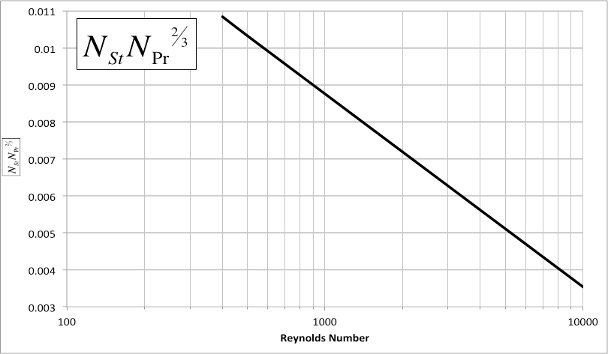

In [14]:
display(Image(filename='N_st_N_pr.jpg')) 

In [15]:
# Prandtl number
k_air = 0.014 #[Btu/hr-ft-°F]
Pr_air = c_p_a * mu_a * 3600/k_air
N_st = 0.009/Pr_air**(2/3)
G = m_dot_air/60/A_min
h_o = N_st * G * c_p_a * 3600
print('Air side heat transfer coefficient is:',f"{h_o:.2f}",'[Btu/hr-ft2-F]') 

Air side heat transfer coefficient is: 21.03 [Btu/hr-ft2-F]


In [16]:
k_water = 0.38 #[Btu/hr-ft-°F]
mu_w = 0.0002317 # [lbm/ft-s]
# assume 4 tubes
G_water = m_dot_water/4/60/A_tube
#Calculate Reynolds Number
Re_water = G_water * D_i/mu_w 
print('Reynold number of water side is:',f"{Re_water:.1f}") 
#Calculate Prandtl Number
Pr_water = c_p_w * mu_w * 3600/k_water
# Calculate Nusselt Number
Nu_water = 0.664*Re_water**(1/2)*Pr_water**(1/3)
h_i = Nu_water * k_water/D_i
print('Water side heat transfer coefficient is:',f"{h_i:.1f}",'[Btu/hr-ft2-F]') 

Reynold number of water side is: 265812.3
Water side heat transfer coefficient is: 3239.9 [Btu/hr-ft2-F]


#### Step 3. Calculate total resistance

In [ ]:
k_tube = 230 #Btu/hr-ft-°F
R_total = 1/(h_i*A_in) + math.log(D_o/D_i)/(2*np.pi*k_tube*L)+1/(h_o*(A_u+eta_fin*A_fin))
UA = 1/R_total

C_air = m_dot_air * c_p_a
C_water = m_dot_water * c_p_w
C_min = min(C_air,C_water)
C_max = max(C_air,C_water)
Cr = C_min/C_max
Ntu = UA/C_min
epsilon = 1-np.exp(-Ntu*(1-Cr))
print('Effectiness is:',f"{epsilon:.6f}") 

effectiness is: 0.999998


#### Step 4. Determine the capacity of the coil:
Calculate capacity of coil based on the inlet temperature of air and water:
$$\dot{Q}_{capacity} = \epsilon C_{min} (T_{w,in}-T_{a,in})$$
Since the capacity of coil also can be calculated based on the heat transfer to air:
$$\dot{Q}_{capacity} = \dot{m}_{air}c_{p,a}(T_{a,out}-T_{a,in})$$
The temperature of air leaving coil is: 
$$T_{a,out} = T_{a,in} + \frac{\dot{Q}_{capacity}}{dot{m}_{air}c_{p,a}}$$
The capacity of coil can be calculated based on the heat transfer from water:
$$\dot{Q}_{capacity} = \dot{m}_{w}c_{p,w}(T_{w,in}-T_{a,out})$$
The water temperature at outlet:
$$T_{w,out} = T_{w,in} - \frac{\dot{Q}_{capacity}}{dot{m}_{water}c_{p,w}}$$

In [21]:
Q_capacity = epsilon * C_min *(T_w_in-T_a_in)
T_a_out = T_a_in + Q_capacity/C_air
T_w_out = T_w_in - Q_capacity/C_water
print('The capacity of heating coil is:',f"{Q_capacity:.1f}",'[Btu/hr]') 
print('The air temperature at outlet is:',f"{T_a_out:.1f}",'[F]') 
print('The water temperature at outlet is:',f"{T_w_out:.1f}",'[F]') 

The capacity of heating coil is: 46179.9 [Btu/hr]
The air temperature at outlet is: 170.0 [F]
The water temperature at outlet is: 93.9 [F]
